**Perry Fox  
Capstone Notebook 2  
pyrus277@gmail.com  
Updated 1/11/2023** 

---

# VineClime - Climate and Qualitative Trends in the California Wine Industry
## Part 2: Exploratory Data Analysis

---

### Contents:

1. [Purpose](#p)
1. [California Wine Production Data Exploration](#cwp)
    - [Feature Dictionary](#cwd_fd)
    - [Visuzalizations](#cwd_viz)
1. [Climate Data Exploration](#acc)
    - [Feature Dictionary](#acc_fd)
    - [Visualizations](#acc_fd)
1. [Reviews Data Exploration](#rev)
    - [Feature Dictionary](#rev_fd)
    - [NLP Prep](#nlp)
1. [Wine Production and Climate Exploration](#wc)
1. [Reviews and Climate Exploration](#rc)

---

<a id="p"></a>
## 1. Purpose: 
This notebook aims to do a deeper exploratory analysis on the datasets gathered in the first notebook. It aims to find patterns and correlations and use those to determine what we might be able to predict using statistical or machine learning models.

In [4]:
# Imports
import numpy as np
import pandas as pd
import shelve
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
# Bring in the wrangled and cleaned data
with shelve.open('capstone_dataframes') as shelfFile:
    cwp = shelfFile['cwp']
    acc = shelfFile['all_county_climates']
    rev = shelfFile['reviews']

---

<a id="cwp"></a>
## 2. California Wine Production Data Exploration (cwp)

In [3]:
print('California Wine Production')
cwp.info()

California Wine Production
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             1315 non-null   int64  
 1   county           1315 non-null   object 
 2   harvested_acres  1302 non-null   float64
 3   yield            1266 non-null   float64
 4   production       1278 non-null   float64
 5   price            1278 non-null   float64
 6   value            1315 non-null   int64  
 7   lat              1315 non-null   float64
 8   lon              1315 non-null   float64
 9   fips             1315 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 102.9+ KB


In [4]:
cwp.describe()

year  harvested_acres        yield    production         price  \
count  1315.000000      1302.000000  1266.000000  1.278000e+03   1278.000000   
mean   2001.171103     14546.443164     5.176288  1.023638e+05    928.027363   
std      11.751631     20576.581018     3.267309  1.711560e+05   1244.949783   
min    1980.000000         3.000000     0.060000  2.300000e+01     74.000000   
25%    1991.000000       805.750000     2.940000  3.259750e+03    335.827500   
50%    2002.000000      3699.000000     4.040000  1.740000e+04    723.500000   
75%    2011.000000     23884.500000     7.185000  1.298860e+05   1236.887500   
max    2020.000000    128613.000000    25.000000  1.040100e+06  36342.070000   

              value          lat          lon  
count  1.315000e+03  1315.000000  1315.000000  
mean   5.961252e+07    37.309497  -120.719004  
std    1.237376e+08     1.725499     1.701907  
min    1.150000e+04    32.715700  -123.438400  
25%    1.600500e+06    36.313600  -121.901800  
50%    1.220210e+07    37.509100  -120.987600  
75%    6.340450e+07    38.502500  -119.696300  
max    2.030002e+09    40.790900  -116.419400

#### Checking for outliers
The max value of $36,342 in the `price` (per ton) column seems very high. Winegrapes could have a range, but this seems extreme and worth looking in to...

In [5]:
# Let's see how many years have a ton of grapes priced over $5000.
cwp.loc[cwp['price'] > 5000]

year      county  harvested_acres  yield  production     price  \
52   2019        Napa          44200.0   3.62    160000.0   5862.26   
90   2018        Napa          43400.0   4.26    185000.0   5614.05   
127  2017        Napa          43600.0   3.26    142000.0   5287.55   
370  2010       Marin            186.0   1.11       207.0   5125.60   
522  2006  SanJoaquin          92501.0   0.06      5610.0  36342.07   

          value      lat       lon   fips  
52    937962000  38.5025 -122.2654  06055  
90   1038600000  38.5025 -122.2654  06055  
127   750832000  38.5025 -122.2654  06055  
370     1061000  38.0834 -122.7633  06041  
522   203879000  37.9176 -121.1710  06077

We see that there are only 5 records where the wine production value is over \\$5000 per ton, and no other comes close to \\$36,342. Maybe San Joaquin is really just that good, though. How is that county priced in other years?:

In [6]:
sj_df = cwp.loc[cwp['county'] == 'SanJoaquin']
sj_df = sj_df.sort_values(by=['price'], ascending=False)
sj_df.head()

year      county  harvested_acres  yield  production     price  \
522  2006  SanJoaquin          92501.0   0.06      5610.0  36342.07   
312  2012  SanJoaquin         109000.0   8.18    892000.0    605.72   
171  2016  SanJoaquin          98000.0   7.31    716000.0    594.67   
135  2017  SanJoaquin          98100.0   6.79    666000.0    593.91   
241  2014  SanJoaquin         102000.0   8.00    816000.0    590.00   

         value      lat      lon   fips  
522  203879000  37.9176 -121.171  06077  
312  540303000  37.9176 -121.171  06077  
171  425781000  37.9176 -121.171  06077  
135  395541000  37.9176 -121.171  06077  
241  481440000  37.9176 -121.171  06077

Yeah, I think we can call that $36,342 a typo, unless 2006 was just REALLY special. I'll replace that value in the main climate dataframe with the San Joaquin average (average not including the outlier, of course).

In [7]:
avg_sj_price = sj_df.loc[:,'price'][1:].mean()
cwp.loc[cwp.index == 522, 'price'] = avg_sj_price

In [9]:
cwp.loc[cwp['price'] > 5000]

year county  harvested_acres  yield  production    price       value  \
52   2019   Napa          44200.0   3.62    160000.0  5862.26   937962000   
90   2018   Napa          43400.0   4.26    185000.0  5614.05  1038600000   
127  2017   Napa          43600.0   3.26    142000.0  5287.55   750832000   
370  2010  Marin            186.0   1.11       207.0  5125.60     1061000   

         lat       lon   fips  
52   38.5025 -122.2654  06055  
90   38.5025 -122.2654  06055  
127  38.5025 -122.2654  06055  
370  38.0834 -122.7633  06041

That looks better, now any analysis we do on price will be more accurate. 

In [ ]:
## Don't run this again.
# # And we'll update the shelved varaible for the modeling notebook:
# with shelve.open('capstone_dataframes') as shelfFile:
#     shelfFile['cwp2'] = cwp
    

<a id="cwd_fd"></a>
### Feature Dictionary

**year** - The year of winegrape production for all varieties. This dataset goes from 1980 to 2000.  
**county** - Lists one out of a total of 41 different California counties that produce winegrapes.  
**harvested_acres** - The number of acres harvested for a given year. We find a minimum of 3 and a maximum of 129,000.  
**yield** - The amount of tons per acre produced  
**production** - The total number of tons produced   
**price** - The value in USD by ton  
**value** - The total value of winegrapes produced in a given year
**lat / lon** - phyical coordinates of the county as given by Google Maps

<a id="cwd_viz"></a>
#### Visualizations
Next, I'll spin up some visualizations to get a sense of California wine production as a whole. Later on, I'll dig into counties. 

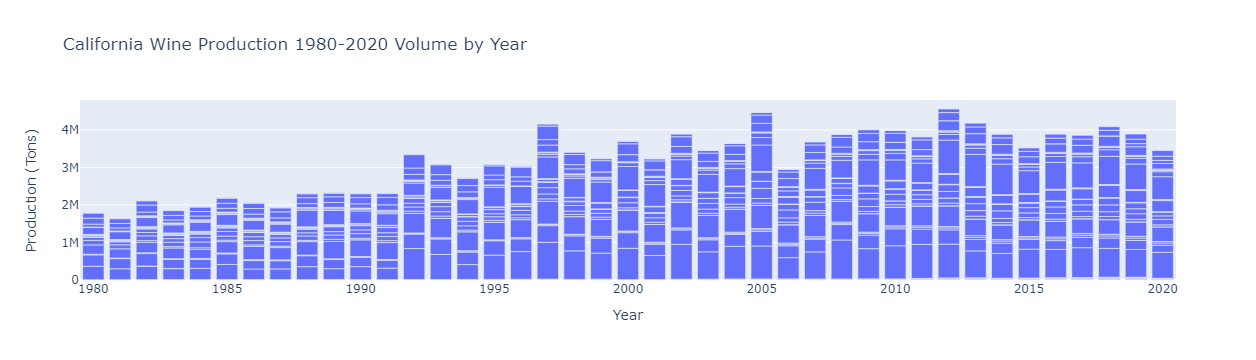

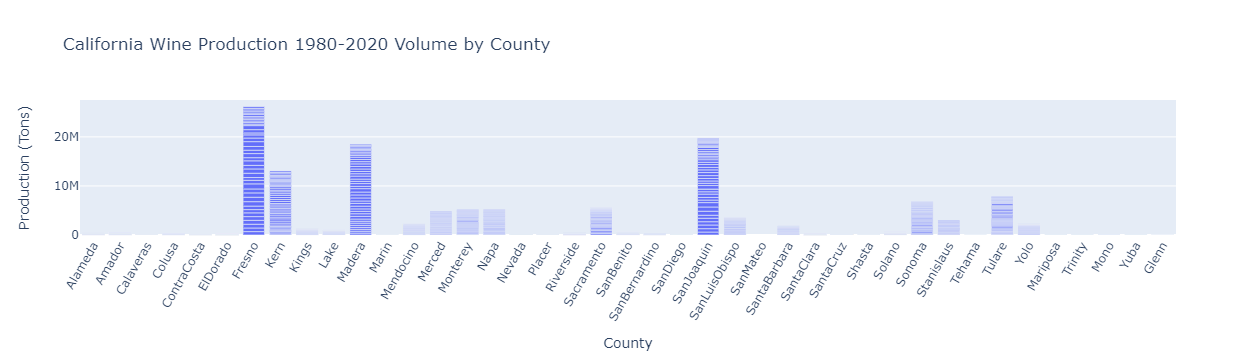

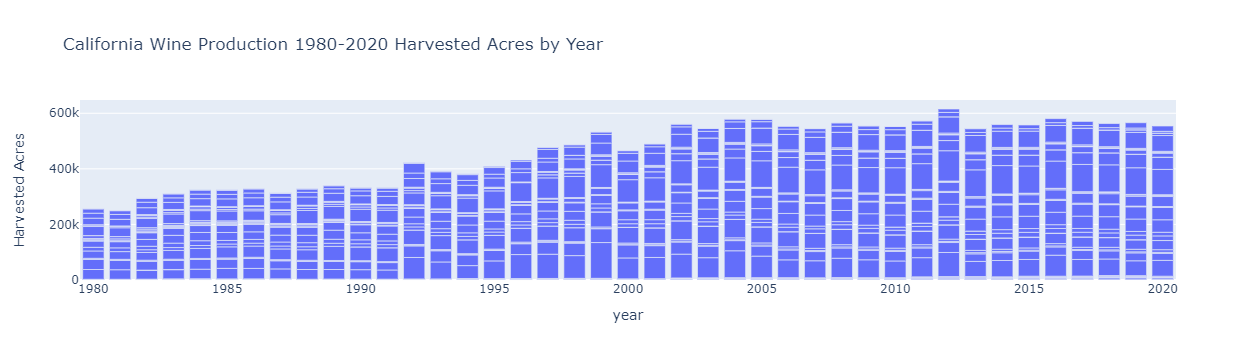

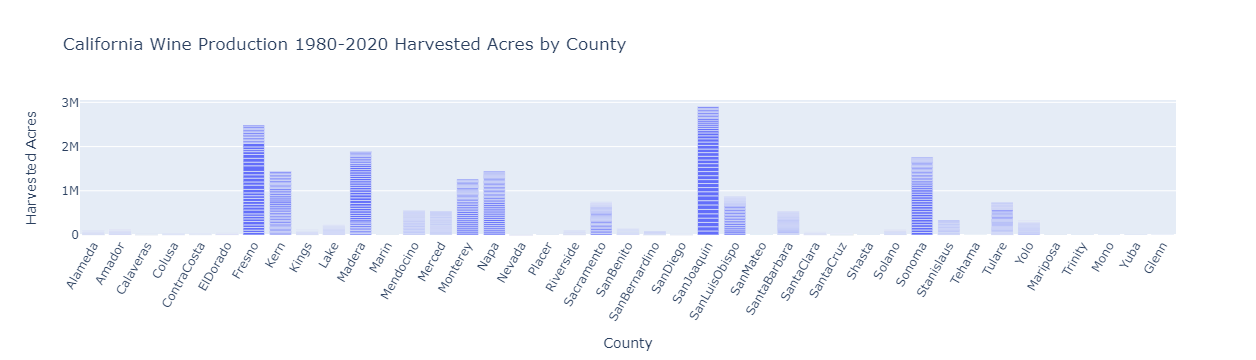

<AxesSubplot:title={'center':'Number Active Years Per County'}, ylabel='Years'>

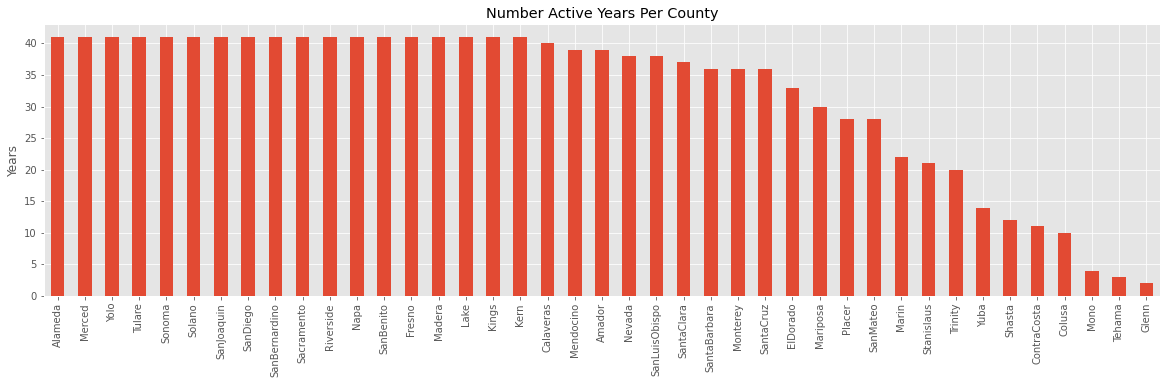

In [10]:
plt.subplots()

fig = px.bar(cwp, x='year', y='production', title = 'California Wine Production 1980-2020 Volume by Year')
fig.update_layout(xaxis_title='Year', yaxis_title='Production (Tons)')
fig.show()  

fig2 = px.bar(cwp, x='county', y='production', title = 'California Wine Production 1980-2020 Volume by County')
fig2.update_layout(xaxis_title='County', yaxis_title='Production (Tons)')
fig2.update_xaxes(tickangle=300)
fig2.show()  

fig3 = px.bar(cwp, x='year', y='harvested_acres', title = 'California Wine Production 1980-2020 Harvested Acres by Year')
fig3.update_layout(xaxis_title='year', yaxis_title='Harvested Acres')
fig3.show()

fig4 = px.bar(cwp, x='county', y='harvested_acres', title = 'California Wine Production 1980-2020 Harvested Acres by County')
fig4.update_layout(xaxis_title='County', yaxis_title='Harvested Acres')
fig4.update_xaxes(tickangle=300)
fig4.show()  

cwp['county'].value_counts().plot(kind='bar', title='Number Active Years Per County', ylabel = "Years",figsize=(20,5))


# fig2 = px.bar(cwp, x='County', y=), title = 'California Wine Production 1980-2020 Harvested Acres by County')
# fig2.update_layout(xaxis_title='County', yaxis_title='Harvested Acres')
# fig2.show() 


#### Key Takeaways:

- Overall production has gradually risen in tons from 1980 to 2005, but from that point forwards it appears to have leveled out. Both the production chart and the harvest volume per acre reflect this.  

- Despite Napa and Sonoma counties often coming to mind when people think of California wine, in terms of production, they appear to be dwarfed over the past 40 years by **Fresno**, **San Joaquin**, **Madera**, and **Kern** counties.

- Wine production and production acreage seems to have leveled out over the past 20 yrs, and may even be tapering down slightly.

- 18 of the 41 counties have been producing wine in each year we have data for. 10 counties have been producing for less than 25 years, and these will be excluded from certain from certain analyses.  

Next, I'll append a fips code column to make county mapping easier in Plotly and Tableau.  
See the Tableau file for further exploratory visualizations!

In [11]:
fips_dict = {'Alameda': '06001', 'Amador': '06005', 'Calaveras': '06009','Colusa': '06011', 'ContraCosta': '06013', 'ElDorado': '06017', 'Fresno': '06019',  'Kern': '06029', 'Kings': '06031',
 'Lake': '06033', 'Madera': '06039', 'Marin': '06041', 'Mendocino': '06045', 'Merced': '06047', 'Monterey': '06053', 'Napa': '06055', 'Nevada': '06057', 'Placer': '06061', 'Riverside': '06065',
 'Sacramento': '06067', 'SanBenito': '06069', 'SanBernardino': '06071', 'SanDiego': '06073', 'SanJoaquin': '06077', 'SanLuisObispo': '06079', 'SanMateo': '06081', 'SantaBarbara': '06083',
 'SantaClara': '06085', 'SantaCruz': '06087', 'Shasta': '06089', 'Solano': '06095', 'Sonoma': '06097', 'Stanislaus': '06099', 'Tehama': '06103', 'Tulare': '06107', 'Yolo': '06113', 'Mariposa': '06043',
 'Trinity': '06105', 'Mono': '06051', 'Yuba': '06115', 'Glenn': '06021'}

In [12]:
cwp['fips'] = cwp['county'].apply(lambda x: fips_dict[x]) 

In [13]:
cwp.head()

year       county  harvested_acres  yield  production    price     value  \
0  2020      Alameda           2530.0   5.14     13000.0  1497.69  19470000   
1  2020       Amador           5360.0   2.31     12400.0  1318.31  16347000   
2  2020    Calaveras            579.0   3.06      1770.0  1325.99   2347000   
3  2020       Colusa            747.0   6.02      4500.0   684.67   3081000   
4  2020  ContraCosta           1940.0   4.69      9090.0   751.27   6829000   

       lat       lon   fips  
0  37.6017 -121.7195  06001  
1  38.3489 -120.7741  06005  
2  38.1960 -120.6805  06009  
3  39.1041 -122.2654  06011  
4  37.8534 -121.9018  06013

In [ ]:
## Don't run this cell again
## store the df with the new column
# with shelve.open('capstone_dataframes') as shelfFile:
#     shelfFile['cwp'] = cwp

In [ ]:
# Write updated wine production data to csv.
cwp.to_csv('California_Wine_Production.csv')

---

<a id="acc"></a>
## 3. Climate Data Exploration

In [129]:
acc.columns[2:]

Index(['annual_profile_moisture', 'annual_root_moisture',
       'annual_surface_moisture', 'annual_precipitation', 'annual_humidity',
       'annual_temperature', 'annual_wind_speed', 'summer_profile_moisture',
       'summer_root_moisture', 'summer_surface_moisture',
       'summer_precipitation', 'summer_humidity', 'summer_temperature',
       'summer_wind_speed', 'winter_profile_moisture', 'winter_root_moisture',
       'winter_surface_moisture', 'winter_precipitation', 'winter_humidity',
       'winter_temperature', 'winter_wind_speed'],
      dtype='object')

In [14]:
print('Climate Data')
acc.info()

Climate Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     1640 non-null   int64  
 1   county                   1640 non-null   object 
 2   annual_profile_moisture  1640 non-null   float64
 3   annual_root_moisture     1640 non-null   float64
 4   annual_surface_moisture  1640 non-null   float64
 5   annual_precipitation     1640 non-null   float64
 6   annual_humidity          1640 non-null   float64
 7   annual_temperature       1640 non-null   float64
 8   annual_wind_speed        1640 non-null   float64
 9   summer_profile_moisture  1640 non-null   float64
 10  summer_root_moisture     1640 non-null   float64
 11  summer_surface_moisture  1640 non-null   float64
 12  summer_precipitation     1640 non-null   float64
 13  summer_humidity          1640 non-null   float64
 14  summer_temp

<a id="acc_fd"></a>
### Feature Dictionary

As mentioned in the Wrangling notebook, the climate data was sourced from the NASA POWER Project website. This compiles data from the Earth System Observatory satellite readings. Data prior to 2015 was compiled from a combination of readings from weather stations, weather balloons, aircraft, ships, satellites and other sources, and processed through reanalysis to give us a complete global climate history going back to 1981. 

**year** - From 1981 to 2020  
**county** - Readings for the same 41 counties in the Ca Wine Production dataset  
#### The features below have means listed by year, cool months (Oct-Mar), and warm months (Apr-Sep):
**profile_moisture** - profile (surface down to bedrock) soil moisture. 0 indicates completely dry soil, and 1 indicates completely saturated soil  
**root_moisture** - root zone (0cm to 100cm below grade) soil moisture. 0 indicates completely dry soil, and 1 indicates completely saturated soil   
**surface_moisture** - surface (0cm to 5cm below grade) soil moisture. 0 indicates completely dry soil, and 1 indicates completely saturated soil  
**precipitation** - total precipitation at the earth's surface (mm/day)  
**humidity** - specific humidity at 2 meters (g/kg)  
**temperature** - The temperature at 2 meters (Celsius)   
**wind_speed** - wind speed at 2 meters (m/s)  

In [15]:
acc.describe()
# A look at the max values reveals no major outliers in this dataset

year  annual_profile_moisture  annual_root_moisture  \
count  1640.000000              1640.000000           1640.000000   
mean   2000.500000                 0.565402              0.572799   
std      11.546917                 0.076718              0.080763   
min    1981.000000                 0.350000              0.350000   
25%    1990.750000                 0.520000              0.520000   
50%    2000.500000                 0.570000              0.570000   
75%    2010.250000                 0.620000              0.630000   
max    2020.000000                 0.760000              0.770000   

       annual_surface_moisture  annual_precipitation  annual_humidity  \
count              1640.000000           1640.000000      1640.000000   
mean                  0.482518              1.705384         5.936213   
std                   0.103804              0.941246         0.941051   
min                   0.170000              0.150000         3.300000   
25%                   0.410000              1.020000         5.250000   
50%                   0.480000              1.560000         5.920000   
75%                   0.552500              2.190000         6.650000   
max                   0.740000              6.620000         8.420000   

       annual_temperature  annual_wind_speed  summer_profile_moisture  \
count         1640.000000        1640.000000              1640.000000   
mean            14.681201           1.808195                 0.520274   
std              2.194249           0.687280                 0.065177   
min              5.000000           0.130000                 0.340000   
25%             13.630000           1.347500                 0.480000   
50%             14.850000           1.910000                 0.520000   
75%             16.080000           2.270000                 0.560000   
max             21.240000           4.120000                 0.700000   

       summer_root_moisture  summer_surface_moisture  summer_precipitation  \
count           1640.000000              1640.000000           1640.000000   
mean               0.522226                 0.381268              0.505049   
std                0.068099                 0.109287              0.356128   
min                0.340000                 0.110000              0.020000   
25%                0.480000                 0.300000              0.240000   
50%                0.520000                 0.370000              0.420000   
75%                0.570000                 0.460000              0.700000   
max                0.710000                 0.680000              2.020000   

       summer_humidity  summer_temperature  summer_wind_speed  \
count      1640.000000         1640.000000        1640.000000   
mean          6.542043           19.297994           1.906323   
std           0.996457            2.679311           0.762272   
min           3.920000           11.070000           0.120000   
25%           5.780000           17.475000           1.427500   
50%           6.500000           19.520000           1.960000   
75%           7.262500           21.172500           2.420000   
max           9.430000           28.110000           4.010000   

       winter_profile_moisture  winter_root_moisture  winter_surface_moisture  \
count              1640.000000           1640.000000              1640.000000   
mean                  0.612470              0.625573                 0.586689   
std                   0.095292              0.100522                 0.114897   
min                   0.360000              0.360000                 0.200000   
25%                   0.550000              0.560000                 0.510000   
50%                   0.610000              0.630000                 0.600000   
75%                   0.680000              0.700000                 0.670000   
max                   0.870000              0.890000                 0.870000   

       winter_precipitation  winter_humidity  winter_temp

In [16]:
acc.head()

year   county  annual_profile_moisture  annual_root_moisture  \
0  1981  Alameda                     0.55                  0.56   
1  1982  Alameda                     0.67                  0.69   
2  1983  Alameda                     0.69                  0.70   
3  1984  Alameda                     0.60                  0.61   
4  1985  Alameda                     0.56                  0.57   

   annual_surface_moisture  annual_precipitation  annual_humidity  \
0                     0.47                  1.74             6.53   
1                     0.63                  2.50             6.53   
2                     0.66                  3.10             7.20   
3                     0.52                  1.09             6.41   
4                     0.48                  1.08             6.10   

   annual_temperature  annual_wind_speed  summer_profile_moisture  \
0               14.22               2.16                     0.50   
1               12.56               2.08                     0.60   
2               13.63               2.16                     0.62   
3               13.83               2.18                     0.50   
4               13.32               2.02                     0.50   

   summer_root_moisture  summer_surface_moisture  summer_precipitation  \
0                  0.50                     0.31                  0.11   
1                  0.61                     0.51                  0.69   
2                  0.63                     0.54                  0.81   
3                  0.50                     0.32                  0.16   
4                  0.50                     0.34                  0.17   

   summer_humidity  summer_temperature  summer_wind_speed  \
0             6.84               17.71               2.51   
1             7.29               16.00               2.32   
2             7.67               16.43               2.30   
3             6.61               18.11               2.50   
4             6.85               17.56               2.34   

   winter_profile_moisture  winter_root_moisture  winter_surface_moisture  \
0                     0.61                  0.63                     0.63   
1                     0.74                  0.78                     0.76   
2                     0.76                  0.78                     0.76   
3                     0.70                  0.72                     0.71   
4                     0.62                  0.64                     0.62   

   winter_precipitation  winter_humidity  winter_temperature  \
0                  3.35             6.26               10.68   
1                  4.31             5.83                9.08   
2                  5.46             6.74               10.79   
3                  2.02             6.16                9.52   
4                  2.00             5.40                9.04   

   winter_wind_speed  
0               1.82  
1               1.82  
2               2.02  
3               1.86  
4               1.69

<a id="acc_viz"></a>
#### Climate Trend Visualizations
Here I'll visualize all the climate features over time. The purpose is to get a sense of which features are changing the fastest and which remain relatively steady, in order to guide further analysis and modeling.

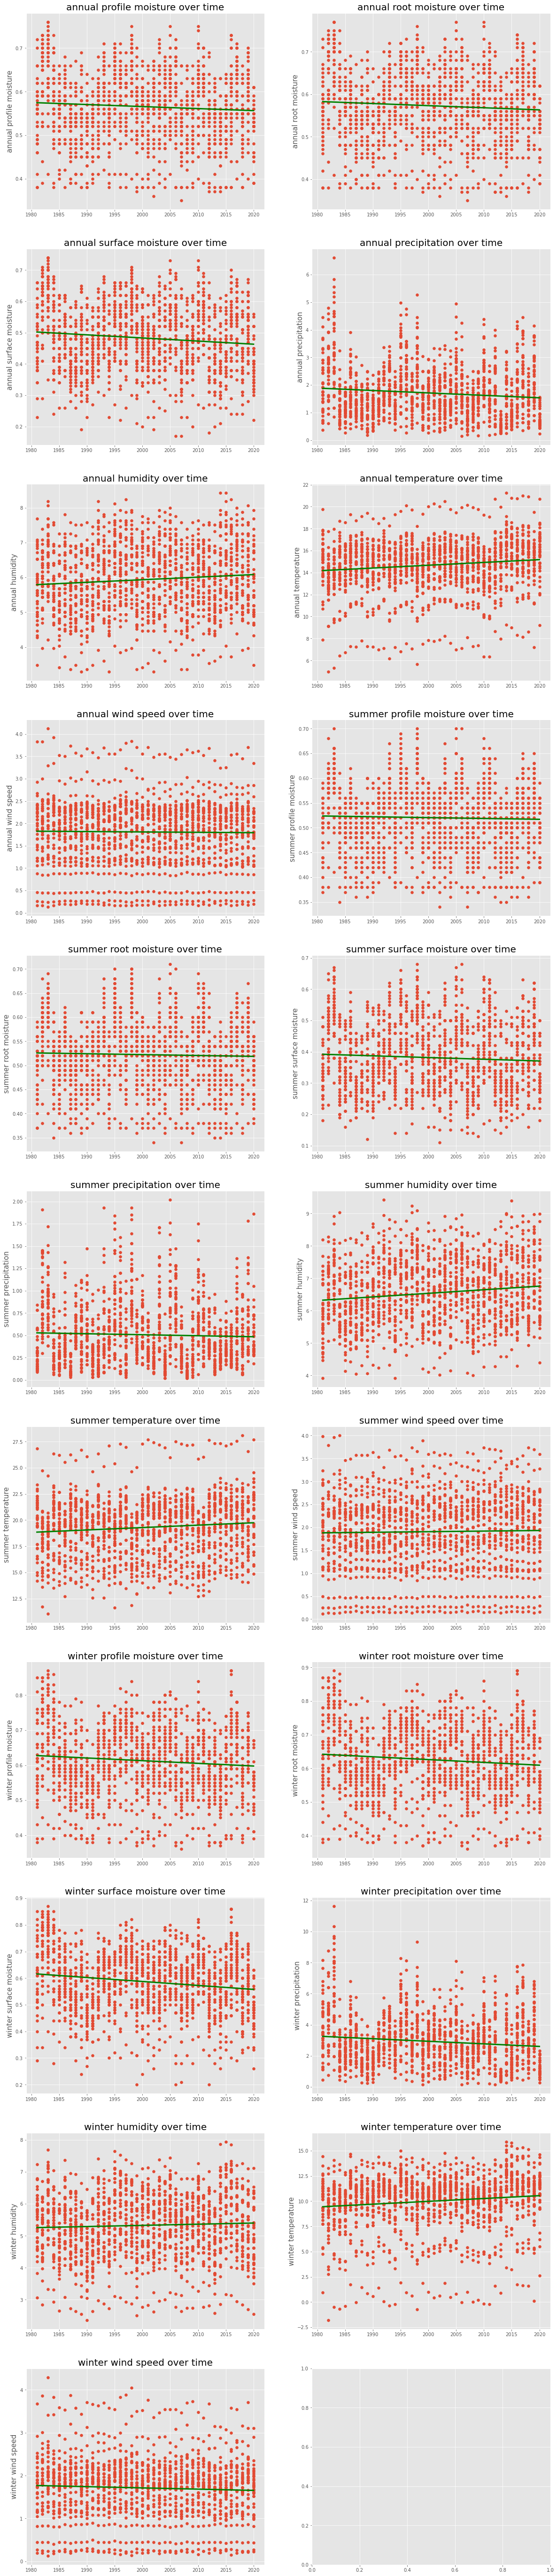

In [17]:
plt.subplots(11,2, figsize=(20,100))

i=1

for col in acc.columns[2:]:
    # Plot the data and best fit line
    x = acc['year']
    y = acc[col]
    a, b = np.polyfit(x, y, 1)
    plt.subplot(11,2,i)
    plt.scatter(x, acc[col])
    plt.plot(x, a*x+b, color='green', linewidth=3)
    plt.ylabel(col.replace("_", " "), fontsize = 15)
    plt.title(f'{col.replace("_", " ")} over time', fontsize = 20)
    
    # increment subplot position
    i+=1

Later on I'll take a look at the R squared values for these relationships, but just looking at the features visualized, the following feature trends seem to stand out:
- annual_surface_moisture - downwards
- annual_humidity - upwards
- annual_temperature - upwards
- summer_temperature - upwards 
- winter_surface_moisture - downwards
- winter_temperature - upwards

--- 

<a id="rev"></a>
## 4. Reviews Data Exploration

In [18]:
print('Reviews')
rev.info()

Reviews
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53949 entries, 10 to 81111
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         53949 non-null  Int64  
 1   county       53949 non-null  object 
 2   title        53949 non-null  object 
 3   points       53949 non-null  int64  
 4   price        53949 non-null  float64
 5   variety      53949 non-null  object 
 6   winery       53949 non-null  object 
 7   description  53949 non-null  object 
dtypes: Int64(1), float64(1), int64(1), object(5)
memory usage: 3.8+ MB


In [19]:
rev.head()

year         county                                              title  \
10  2011             NA  Kirkland Signature 2011 Mountain Cuvée Caberne...   
12  2012           Napa  Louis M. Martini 2012 Cabernet Sauvignon (Alex...   
14  2012     SantaClara           Mirassou 2012 Chardonnay (Central Coast)   
23  2011  SanLuisObispo  Bianchi 2011 Signature Selection Merlot (Paso ...   
25  2011           Napa  Castello di Amorosa 2011 King Ridge Vineyard P...   

    points  price             variety               winery  \
10      87   19.0  Cabernet Sauvignon   Kirkland Signature   
12      87   34.0  Cabernet Sauvignon     Louis M. Martini   
14      87   12.0          Chardonnay             Mirassou   
23      87   22.0              Merlot              Bianchi   
25      87   69.0          Pinot Noir  Castello di Amorosa   

                                          description  
10  Soft, supple plum envelopes an oaky structure ...  
12  Slightly reduced, this wine offers a chalky, t...  
14  Building on 150 years and six generations of w...  
23  This wine from the Geneseo district offers aro...  
25  Oak and earth intermingle around robust aromas...

<a id="rev_fd"></a>
### Reveiws Data Feature Dictionary

**year** - From 1985 to 2019  
**county** - An incomplete column engineered from the winery column by webscraping. We hope enough of the counties line up with the other two datasets for us to draw some conclusions  
**title** - information from the bottle label  
**points** - taster rating on a scale of 1-100. However, only scores of 80 and above make it to publication, and therefore, this the range for this feature is 80-100  
**price** - price in USD  
**variety** - grape varietal or blend style.  
**winery** - producer of wine  
**description** - text of taster's review  


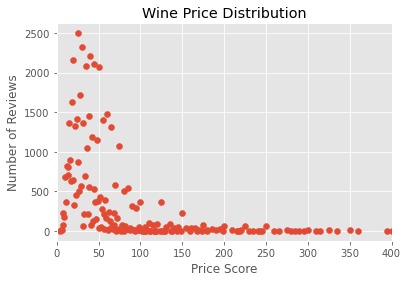

In [20]:
# Plot distribution of wine prices
ratings = rev.price.value_counts().sort_index()
plt.figure()
plt.scatter(ratings.index, ratings)
plt.xlabel('Price Score')
plt.ylabel('Number of Reviews')
plt.title('Wine Price Distribution')
plt.xlim([0,400])
plt.show()

In [21]:
wine_ct_sub200 =rev.loc[rev['price'] < 200].price.count()
wine_ct = rev.price.count()
pct = round((wine_ct_sub200/wine_ct)*100, 2)
print(f'For all wines listed with a price value, {pct}% of them are below $200 a bottle')

For all wines listed with a price value, 99.38% of them are below $200 a bottle


In [22]:
# Just for the heck of it, let's see the most expensive bottles. 
rev.loc[rev['price'] > 1000]

year        county                                              title  \
120391  2013  SantaBarbara  Blair 2013 Roger Rose Vineyard Chardonnay (Arr...   
71648   2018            NA     Sean Minor 2018 Nicole Marie Red (North Coast)   

        points   price     variety      winery  \
120391      91  2013.0  Chardonnay       Blair   
71648       86  2018.0  Red Blends  Sean Minor   

                                              description  
120391  The nose on this single-vineyard wine from a s...  
71648   Vanilla and marshmallow aromas lead to effusiv...

The most expensive bottle reviewed only got an 86. Cost doesn't always mean quality.

#### Here is the score distibution

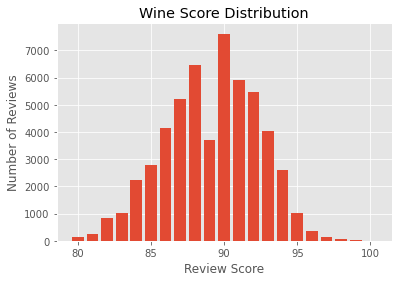

In [23]:
# Plot distribution of wine scores
ratings = rev.points.value_counts().sort_index()
plt.figure()
plt.bar(ratings.index, ratings)
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.title('Wine Score Distribution')
plt.show()

In [24]:
print(f'Average Score: {round(rev.points.mean(), 2)}')

Average Score: 89.17


I won't do a breakdown by county since we know this data is incomplete as explained in the Wrangling notebook. To generalize about counties for an analysis, I'll collect only those lines we have a county listing for.  
Valuable information is in the reviews column, and in the next section we'll take a look at that information and prepare it for modeling. 

<a id="nlp"></a>
## NLP Prep

In this section we will look at the entirety of the review data for an initial NLP exploration.  
From that we'll define a specific vocabulary list for flavor descriptors, tokenize it, and track token useage over time and by place. 

Here's an example of some review text:

In [27]:
rev[['description', 'points']].sample(5)

description  points
90310  Crisp and fresh aromas of lime sorbet and iced...      88
26455  A nontraditional blend of 44% Zinfandel, 31% S...      93
24353  This seems to be losing its freshness and appe...      86
79916  This simple blend of Zinfandel, Syrah and seve...      83
24470  This Pinot's immediate lusciousness belies its...      92

In [28]:
eng_stopwords = stopwords.words('english')

Here, we'll set up a tokenizer to get a sense of the most common words used in general:

In [29]:
# Base tokenizer
def tokenizer(text):
    '''
    Input: A pandas series, or column from a dataframe
    Output: A word count sparse matrix represented in a Pandas dataframe 
    '''
    # remove punctuation and numbers, and convert to lowercase
    for char in (string.punctuation + '0123456789'):
        text = text.replace(char,'').lower()
        
    # create a list of words, breaking the text up by spaces
    word_list = text.split(' ')
    # set up a list for the selected words to land in
    selected_word_list = []
    
    # remove stopwords and empty strings
    for word in word_list:
        if (not word in eng_stopwords) and (word !=''):
            selected_word_list.append(word)
    return selected_word_list
    

In [30]:
def make_sparse_matrix(text_series):
    '''
    Input: A pandas series that with a single column
    Output: A word count sparse matrix represented in a Pandas dataframe 
    '''
    # 1. Instantiate
    bagofwords = CountVectorizer(min_df = 5,
                                 tokenizer=tokenizer)
    # 2. Fit
    bagofwords.fit(text_series)

    # 3. Transform - this is a sparse matrix
    text_series_transformed = bagofwords.transform(text_series)
    
    # Load this up into a dataframe that we can merge in with our numeric data
    sparse_matrix_df = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=text_series_transformed.toarray())
    

    return sparse_matrix_df 

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
sp_matrix_desc = make_sparse_matrix(rev.description) # this tokenizes the given text field
base_series_500 = sp_matrix_desc.sum(axis=0).sort_values(ascending=False).head(500)

C:\Users\pyrus\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Here's a wordcloud of the raw list:

(-0.5, 799.5, 399.5, -0.5)

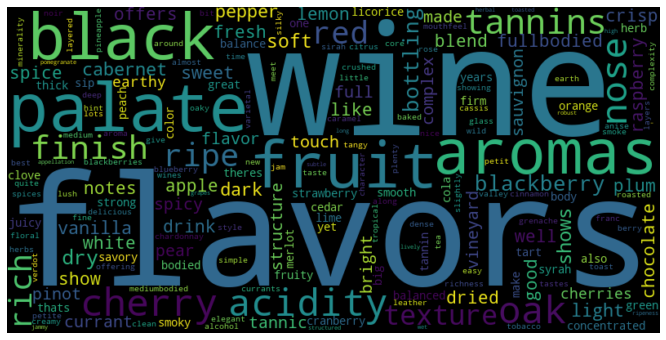

In [32]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(base_series_500)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Makes for an interesting visual, but if we want to dig in to the subjective qualities of the wines across this massive number of reviews, it helps to only look for **flavor descriptors** and tokenize those for analysis.  
We'll use this list of 500 words and manually remove each word that is not a flavor descriptor (as per the opinion of this former beverage professional.)

In [33]:
base_words_500 = list(base_series_500.index)

In [ ]:
# # no need to run this again
# with open("base_list.txt", "w") as fhand:
#     fhand.write("\n".join(base_words_500))

`base_list.txt` is the 500 most common tokens from all the wine reviews.  
`selected_list.txt` is a curated list where I kept only the words most relevant to **describing flavor**

In [34]:
with open("selected_list.txt", "r") as fhand:
    vocab_lst = [line.rstrip() for line in fhand]

Here is `selected_list.txt` read in as a list which we can get word counts for by feature:

Here are the flavor words, back in this notebook for use:

In [35]:
len(vocab_lst)

298

In [36]:
vocab_lst[0:10]

['fruit',
 'black',
 'cherry',
 'acidity',
 'oak',
 'ripe',
 'rich',
 'blackberry',
 'dry',
 'soft']

Tokenize again using our special vocab list:

In [37]:
# flavor word tokenizer
def flavor_tokenizer(text):
    '''
    Input: A pandas series, or column from a dataframe
    Output: A word count sparse matrix represented in a Pandas dataframe 
    '''
    # remove punctuation and numbers, and convert to lowercase
    for char in (string.punctuation + '0123456789'):
        text = text.replace(char,'').lower()
        
    # create a list of words, breaking the text up by spaces
    word_list = text.split(' ')
    # set up a list for the selected words to land in
    selected_word_list = []
    
    # remove non-flavpor words, stopwords, and empty strings
    for word in word_list:
        if (not word in eng_stopwords) and (word in vocab_lst) and (word !=''):
            selected_word_list.append(word)
    return selected_word_list

In [38]:
def make_flavor_sparse_matrix(text_series):
    '''
    Input: A pandas series that with a single column
    Output: A word count sparse matrix represented in a Pandas dataframe 
    '''
    # 1. Instantiate
    bagofwords = CountVectorizer(min_df = 5,
                                 tokenizer=flavor_tokenizer)
    # 2. Fit
    bagofwords.fit(text_series)

    # 3. Transform - this is a sparse matrix
    text_series_transformed = bagofwords.transform(text_series)
    
    # Load this up into a dataframe that we can merge in with our numeric data
    sparse_matrix_df = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=text_series_transformed.toarray())
    

    return sparse_matrix_df 

In [39]:
def get_top_words(series, n_count = 100):
    '''
    Input: a pandas series or df column, and an int for the number of top words to count. 
    Output: word count series for the top n most frequent word
    '''
    sp_matrix_desc = make_flavor_sparse_matrix(series) # this tokenizes the given text field
    word_counts = sp_matrix_desc.sum(axis=0).sort_values(ascending=False).head(n_count)
    
    return word_counts
    # Follow this function up with visualzation-- word cloud or historgram
    

In [40]:
# this cell takes a little bit of time
base_flavor_word_series = get_top_words(rev.description, 100)
base_flavor_word_series

C:\Users\pyrus\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



fruit        13610
black        13548
cherry       12948
acidity      12294
oak          12059
             ...  
tea           1588
petite        1549
caramel       1545
creamy        1537
character     1532
Length: 100, dtype: int64

#### Here is our word cloud for the all of the reviews data, only looking for selected flavor descriptors

(-0.5, 799.5, 399.5, -0.5)

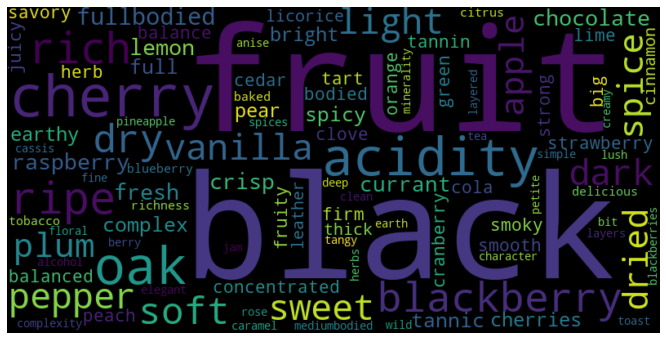

In [41]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(base_flavor_word_series)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

That looks different from the first one. 
Lets produce a sequence of these over a few years to help visualze the changes:

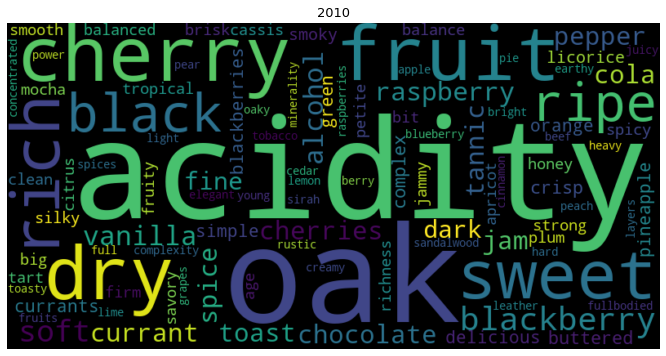

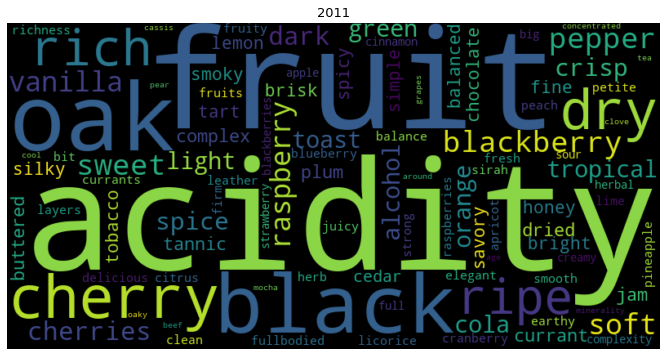

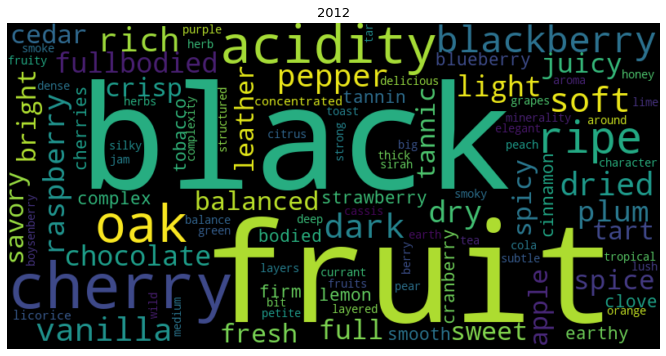

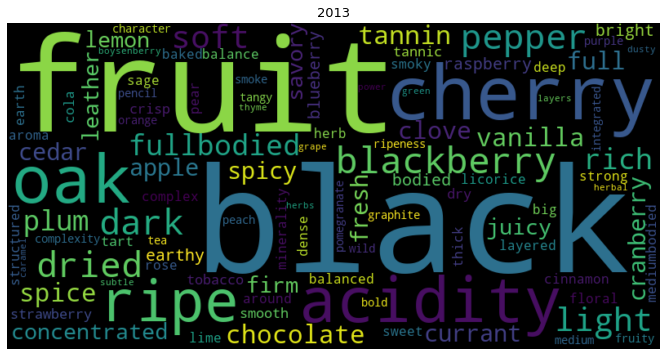

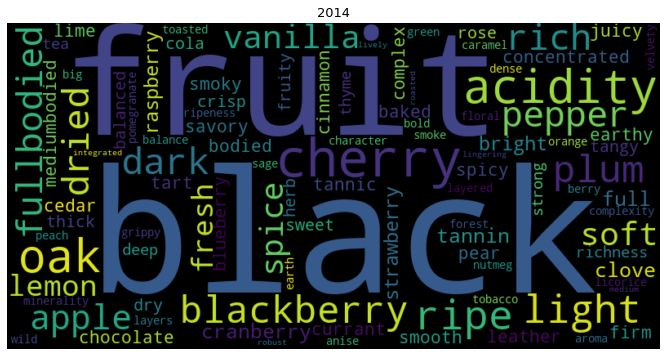

In [47]:
for year in range(2010, 2015):
    
    yr_rev = rev.loc[rev['year'] == year]
    base_flavor_word_series = get_top_words(yr_rev.description,100)
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(base_flavor_word_series)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(year, fontsize=13)
    plt.axis("off")
  

Looks like acidity really went out of style after 2011 and black fruit took over!
  
Next, we'll grab top 20 word counts for each year from 1997 to 2020 so we can use them in an correlation analysis:

In [ ]:
# Grab the top 20 words from each year from 1997 to 2020 and put them in a dataframe
frame = {}
for year in range(1997, 2020):
    yr_rev = rev.loc[rev['year'] == year]
    frame[year] = get_top_words(yr_rev.description,20)
top_words_by_year = pd.DataFrame(frame)

In [70]:
# Convert NaN columns to 0
top_words_by_year= top_words_by_year.fillna(0)

In [71]:
# Normalize the counts to pecentages
for column in top_words_by_year.columns:
    top_words_by_year[column] = round((top_words_by_year[column]/top_words_by_year[column].sum())*100,2)

In [72]:
# Let's see it
top_words_by_year.head()

1997  1998  1999  2000  2001  2002  2003  2004  2005  2006  2007  \
acidity   0.0  4.27  5.36  6.48  8.19  7.69  4.05   0.0  2.94  5.54  5.87   
acids     0.0  0.00  3.71  3.46  5.33  0.00  0.00   0.0  0.00  0.00  0.00   
age       0.0  0.00  0.00  0.00  0.00  0.00  4.86   0.0  0.00  0.00  0.00   
alcohol   0.0  0.00  0.00  0.00  0.00  0.00  0.00   0.0  0.00  0.00  0.00   
apple     0.0  0.00  0.00  0.00  4.00  5.13  0.00   0.0  0.00  0.00  0.00   

         2008  2009  2010   2011  2012  2013  2014  2015  2016  2017  2018  \
acidity  7.11  7.44  8.86  10.34  7.95  6.09  6.72  8.72  8.34  8.14  7.68   
acids    0.00  0.00  0.00   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
age      0.00  0.00  0.00   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
alcohol  0.00  0.00  3.21   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
apple    0.00  0.00  0.00   0.00  0.00  0.00  3.48  4.99  4.34  5.26  7.02   

         2019  
acidity  6.13  
acids    0.00  
age      0.00  
alcohol  0.00  
apple    3.07

In [117]:
# Transpose this dataframe so you can line it up with climate features by year
top_words_transpose = top_words_by_year.transpose()

In [74]:
top_words_transpose.head(10)

acidity  acids   age  alcohol  apple  balance  berry   bit  black  \
1997     0.00   0.00  0.00      0.0   0.00      0.0   0.00  0.00   5.99   
1998     4.27   0.00  0.00      0.0   0.00      2.8   4.54  0.00   3.20   
1999     5.36   3.71  0.00      0.0   0.00      0.0   3.30  0.00   4.95   
2000     6.48   3.46  0.00      0.0   0.00      0.0   3.16  3.31   0.00   
2001     8.19   5.33  0.00      0.0   4.00      0.0   0.00  0.00   0.00   
2002     7.69   0.00  0.00      0.0   5.13      0.0   0.00  0.00   0.00   
2003     4.05   0.00  4.86      0.0   0.00      0.0   0.00  0.00   4.86   
2004     0.00   0.00  0.00      0.0   0.00      0.0   0.00  0.00   5.31   
2005     2.94   0.00  0.00      0.0   0.00      0.0   0.00  0.00   6.48   
2006     5.54   0.00  0.00      0.0   0.00      0.0   0.00  0.00   5.71   

      blackberries  blackberry  bright  cassis  cedar  cherries  cherry  \
1997          0.00        4.53     0.0    3.86   3.33      0.00    5.99   
1998          0.00        0.00     0.0    0.00   0.00      0.00    3.60   
1999          0.00        4.95     0.0    0.00   0.00      0.00    4.40   
2000          0.00        0.00     0.0    0.00   0.00      0.00    5.57   
2001          0.00        0.00     0.0    0.00   0.00      3.24    4.38   
2002          0.00        0.00     0.0    0.00   0.00      0.00    5.13   
2003          3.24        5.67     0.0    3.24   0.00      5.26    8.50   
2004          4.36        6.56     0.0    3.10   0.00      4.42    9.07   
2005          4.10        6.55     0.0    0.00   0.00      5.24    7.76   
2006          4.36        3.70     0.0    0.00   0.00      5.74    6.52   

      chocolate  citrus  clean  clove  coffee  cola  complex  creamy  crisp  \
1997       3.86    0.00   0.00    0.0    4.26   0.0     3.60    0.00   0.00   
1998       0.00    0.00   0.00    0.0    0.00   0.0     3.20    0.00   0.00   
1999       3.43    0.00   0.00    0.0    0.00   0.0     0.00    0.00   0.00   
2000       3.61    4.52   0.00    0.0    0.00   0.0     4.82    0.00   0.00   
2001       0.00    5.52   3.62    0.0    0.00   0.0     0.00    3.81   5.14   
2002       0.00    4.27   5.13    0.0    0.00   0.0     0.00    0.00   4.27   
2003       3.64    0.00   0.00    0.0    0.00   0.0     0.00    0.00   0.00   
2004       4.53    0.00   0.00    0.0    0.00   0.0     2.80    0.00   0.00   
2005       4.92    0.00   0.00    0.0    0.00   0.0     0.00    0.00   0.00   
2006       3.30    0.00   0.00    0.0    0.00   3.4     0.00    0.00   3.79   

      currant  currants  dark  dried    dry  earth  earthy  even  fine  fresh  \
1997     0.00      0.00  5.19    0.0   4.66   3.33     0.0  4.26  3.46   0.00   
1998     0.00      0.00  2.94    0.0   6.68   0.00     0.0  0.00  0.00   0.00   
1999     0.00      0.00  0.00    0.0   8.38   0.00     0.0  0.00  3.02   0.00   
2000     0.00      0.00  0.00    0.0   9.79   0.00     0.0  0.00  0.00   0.00   
2001     0.00      0.00  0.00    0.0   6.86   0.00     0.0  0.00  0.00   0.00   
2002     0.00      0.00  0.00    0.0   7.69   0.00     0.0  0.00  5.13   6.84   
2003     5.26      3.24  0.00    0.0  10.12   0.00     0.0  0.00  0.00   0.00   
2004     4.95      2.92  0.00    0.0   7.82   0.00     0.0  0.00  0.00   0.00   
2005     5.34      4.48  0.00    0.0   8.51   0.00     0.0  0.00  2.96   0.00   
2006     3.32      4.76  0.00    0.0  10.13   0.00     0.0  0.00  0.00   0.00   

      fruit  fruity  full  fullbodied  grapefruit  green   hot  jam  lemon  \
1997  16.11    0.00  4.53         0.0         0.0   0.00  0.00  0.0    0.0   
1998  19.49    4.54  0.00         0.0         0.0   0.00  0.00  0.0    0.0   
1999  10.71    3.98  0.00         0.0         0.0   0.00  0.00  0.0    0.0   
2000   9.19    0.00  0.00         0.0         0.0   3.61  0.00  0.0    0.0   
2001   6.67    3.62  0.00         0.0         0.0   0.00  0.00  0.0    0.0   
2002   4.27    5.13  0.00         0.0         0.0   0.00  0.00  0.0    0.0   
2003   3.64    0.00  0.00         0.0         

In [ ]:
# Export this to a csv
top_words_transpose.to_csv('top_words.csv')

--- 

<a id="wc"></a>
### 5. Wine Production Data and Climate Data 

How do climate features affect **production** and **value** levels?
In this section we combine the wine production and climate datasets and explore correlations.

In [76]:
# Line up the Production and Climate datasets on year and county
cwp_acc = cwp.merge(acc, on = ['year','county'], how = 'inner') 

Note: The wine production dataset beings in 1980, and the climate data 1981. On an inner type merge, the resulting dataset will have 1293 rows. 

In [77]:
cwp_acc.columns

Index(['year', 'county', 'harvested_acres', 'yield', 'production', 'price',
       'value', 'lat', 'lon', 'fips', 'annual_profile_moisture',
       'annual_root_moisture', 'annual_surface_moisture',
       'annual_precipitation', 'annual_humidity', 'annual_temperature',
       'annual_wind_speed', 'summer_profile_moisture', 'summer_root_moisture',
       'summer_surface_moisture', 'summer_precipitation', 'summer_humidity',
       'summer_temperature', 'summer_wind_speed', 'winter_profile_moisture',
       'winter_root_moisture', 'winter_surface_moisture',
       'winter_precipitation', 'winter_humidity', 'winter_temperature',
       'winter_wind_speed'],
      dtype='object')

To begin, below is a correlation table of production features and just the **annual** climate feature means. Further down we'll look at the seasonal climate feature correlations.

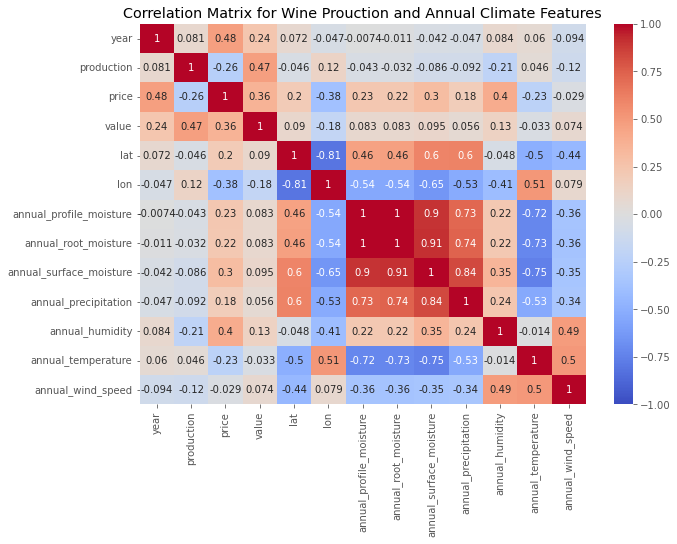

In [78]:
annual_df = cwp_acc[['year', 'production', 'price', 'value', 'lat', 'lon', 'annual_profile_moisture', 'annual_root_moisture', 'annual_surface_moisture',
       'annual_precipitation', 'annual_humidity', 'annual_temperature','annual_wind_speed']].dropna().corr()

plt.figure(figsize=(10,7))
sns.heatmap(annual_df, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True).set(title='Correlation Matrix for Wine Prouction and Annual Climate Features')
plt.show()

The `price`, `value`, and `production` features will be a focus here because these are of interest to wine growers and sellers. It isn't unexpected that we see mild correlations here at best. While climate is changing, on the scale we're looking at, it's very gradual. However, it is interesting to note the correlations between `price` and `annual_humidity` of 0.26. It makes intuitive sense that wetter locations produce more, but humidity has more than twice the correlation value than precipitation.  
  
Let's see if the seasonal averages show any other interesting correlations for these three production features:

In [79]:
corrdf_seasonal.index

NameError: name 'corrdf_seasonal' is not defined

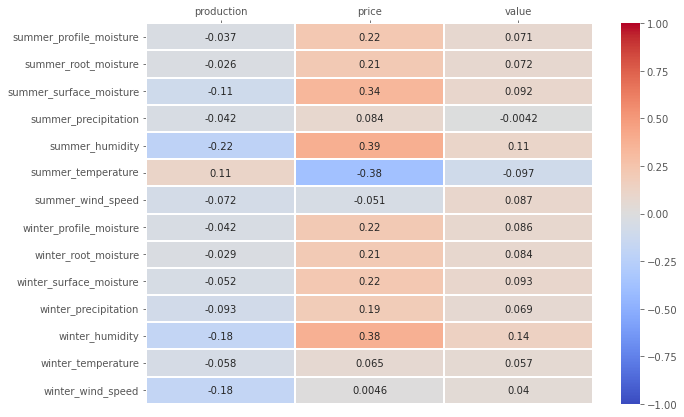

In [80]:
corrdf = cwp_acc.dropna().corr()
corrdf_seasonal = corrdf.iloc[15:,3:6]

plt.figure(figsize=(10,7))

hm = sns.heatmap(corrdf_seasonal, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, linewidth=.01)
# hm.set(title='Wine Production and Seasonal Climate Feature Correlations')
hm.xaxis.tick_top()


# sns.reset_orig

plt.show()

`price`, `production`, and `value` correlations do not appear much more interesting when compared to the summer or winter climate feature means. However, it is noteable that `winter_temperature` has almost no bearing on `price` (-0.065), but `summer_temperature` has a mild, but distinct negative correlation (-0.38). 

Considering the varied geography of California with its wide range in elevations, distances from the ocean, and multitudes of microclimates, it's expected that the correlations would even out when looking at the wine producing landmass as a whole. What's more interesting--and more actionable--is information at the county level, and that's what we'll explore next and also center our modeling around.   
  
Let's go thorough the counties and find absolute correlation values over .5 for the intersections of the all the climate features, and `production` in tons, `price` per ton, and total `value` of annual harvest.
  
This will identify what we'll call the 'sensitive counties', for certain climate features.

In [81]:
# Grab the county list, omitting counties that have fewer than 25 years of production. 
counties = cwp.groupby(['county']).count()['year']
counties = counties[counties >= 25]
counties = list(counties.index)

In [82]:
county_name = []
climate_feature = []
production_metric = []
corr_coef = []

for county in counties:
    # make dataframes of the production and climate data for each county individually
    single_cnty_df = cwp_acc.loc[cwp_acc['county'] == county]
    # drop na and make a correlation matrix
    single_cnty_df = single_cnty_df.dropna().corr()
    # grab only the production, price, and value columns, and only the climate feature rows
    single_cnty_df = single_cnty_df.iloc[8:,3:6]
    
    # iterate thru these single county correlation matrices and return correlations over a
    # specified threshold (.5), storing the measures in their corresponding lists
    for i, j in single_cnty_df.iterrows():
        if j['production'] > abs(.5):
            county_name.append(county)
            climate_feature.append(i)
            production_metric.append('production')
            corr_coef.append(round(j['production'],4))    
        if j['price'] > abs(.5):
            county_name.append(county)
            climate_feature.append(i)
            production_metric.append('price')
            corr_coef.append(round(j['price'],4)) 

In [83]:
# Create a dataframe to easily view and summarize the climate sensitive counties
data = {'county_name': county_name,
        'climate_feature': climate_feature,
        'production_metric': production_metric,
        'correlation': corr_coef}
sensitive_counties = pd.DataFrame(data)

#### Here are the top 10 highest correlation scores:
There are 28 total records with a correlation score over .5

In [85]:
sensitive_counties.sort_values('correlation', ascending=False).head(10)

county_name     climate_feature production_metric  correlation
13         Placer  annual_temperature             price       0.6959
26         Solano   summer_wind_speed        production       0.6570
14         Placer  summer_temperature             price       0.6357
18     Sacramento   summer_wind_speed        production       0.6141
25     SantaClara   summer_wind_speed             price       0.6081
4        ElDorado  annual_temperature             price       0.6066
1         Alameda     summer_humidity             price       0.6008
20  SanBernardino  annual_temperature             price       0.5962
2         Alameda   summer_wind_speed        production       0.5860
22     SanJoaquin   summer_wind_speed        production       0.5784

#### Which climate features are the most common? i.e. Which climate features potentially have the biggest impact on wine production and value?:

In [86]:
sensitive_counties.climate_feature.value_counts()

summer_wind_speed     7
annual_temperature    7
summer_humidity       5
winter_temperature    4
summer_temperature    3
annual_humidity       1
annual_wind_speed     1
Name: climate_feature, dtype: int64

In the next notebook, Modeling, I'll do a predictive analysis using time series models with a focus on the counties and climate features most impactful to wine as detrmined here.

In [ ]:
cwp_acc.to_csv('production_and_climate.csv', index=False) # export for Tableau

<a id="rc"></a>
### 6. Review Data and Climate Data 

#### Can we see if certain climate features are associated with specific flavor words?

Let's first see if root_moisture is correlated with any of the flavor tokens we've isolated above:

In [118]:
# prep the top words df so it can be merged with a climate feature df:
# make the year index a column
top_words_transpose = top_words_transpose.reset_index()
# rename that column to year
top_words_transpose.rename(columns={'index':'year'}, inplace=True)

For each climate feature, show the 5 most positively correlated flavor descriptors, and show the 5 most negatively correlated flavor descriptors.

In [180]:
def climate_flavors(feature):
    # set up the annual values for the supplied climate feature in a df
    feat_df = acc[['year', 'county', feature]]
    feat_df = feat_df.loc[(feat_df['year'] >= 1997) & (feat_df['year'] <= 2019)]
    feat_df = feat_df.groupby(['year']).mean()

    # combine this climate feature df with the word count dataframe, and join by year
    feat_words = feat_df.merge(top_words_transpose, on = 'year')
    
    # set up the correlations
    feat_corr = feat_words.corrwith(feat_words[feature])
    feat_corr = pd.DataFrame({f'{feature.replace("_"," ")} correlations':feat_corr}).drop('year')
    feat_corr = feat_corr.sort_values(f'{feature.replace("_"," ")} correlations', ascending=False) 
    
    print(f'The five flavor descriptors most positively correlated with {feature.replace("_"," ")}:')
    display(feat_corr[1:6]) # removing index zero because the highest cliamte correlation is with itself.   
    
    print(f'The five flavor descriptors most negatively correlated with {feature.replace("_"," ")}:')
    display(feat_corr.tail().sort_values(f'{feature.replace("_"," ")} correlations'))

In [181]:
climate_flavors('annual_root_moisture')

The five flavor descriptors most positively correlated with annual root moisture:


annual root moisture correlations
toast                                0.497840
balance                              0.464278
spicy                                0.289968
berry                                0.278180
strawberry                           0.262176

The five flavor descriptors most negatively correlated with annual root moisture:


annual root moisture correlations
pepper                              -0.404506
dried                               -0.326211
fullbodied                          -0.306560
plum                                -0.262867
tannin                              -0.230240

In [7]:
len(acc.columns[2:])

21

With this function we can now show which climate factors are associated with which flavor descriptors. For example, above we see that wetter soil thorughtout the year is associated with toast, balance, spicy, berry, and strawberry flavor notes. The negative correlations mean that drier soil throughout the year yields wine that has pepper notes (which can be quite pleasant in certain reds), and dried, fullbodies, plum, and tanning descriptors.  

Growers could take note of something like this and keep their fields slightly drier if they want to encourage, or discourage certain flavors. 

For me,  this part above was the most interesting finding in the project. We know climate affects flavor, but here we reveal some insight into exactly how. I definitely want to expand on this.

#### ...Wrapping up the notebook by doing it for all the climate features (there are some interesting correlations):

In [182]:
for feature in acc.columns[2:]:
    climate_flavors(feature)    

The five flavor descriptors most positively correlated with annual profile moisture:


annual profile moisture correlations
toast                                   0.496367
balance                                 0.471546
spicy                                   0.289992
berry                                   0.277554
strawberry                              0.265658

The five flavor descriptors most negatively correlated with annual profile moisture:


annual profile moisture correlations
pepper                                 -0.405796
dried                                  -0.315699
fullbodied                             -0.297262
plum                                   -0.254793
clove                                  -0.220595

The five flavor descriptors most positively correlated with annual root moisture:


annual root moisture correlations
toast                                0.497840
balance                              0.464278
spicy                                0.289968
berry                                0.278180
strawberry                           0.262176

The five flavor descriptors most negatively correlated with annual root moisture:


annual root moisture correlations
pepper                              -0.404506
dried                               -0.326211
fullbodied                          -0.306560
plum                                -0.262867
tannin                              -0.230240

The five flavor descriptors most positively correlated with annual surface moisture:


annual surface moisture correlations
toast                                 0.560544
balance                               0.505613
spicy                                 0.362271
berry                                 0.343895
tropical                              0.308651

The five flavor descriptors most negatively correlated with annual surface moisture:


annual surface moisture correlations
dried                                  -0.385483
fullbodied                             -0.363451
pepper                                 -0.338272
plum                                   -0.298161
clove                                  -0.263477

The five flavor descriptors most positively correlated with annual precipitation:


annual precipitation correlations
toast                                0.536502
balance                              0.441117
strawberry                           0.365446
alcohol                              0.298426
lively                               0.284229

The five flavor descriptors most negatively correlated with annual precipitation:


annual precipitation correlations
tannin                              -0.504148
clove                               -0.504148
pepper                              -0.429441
blackberry                          -0.306136
black                               -0.259087

The five flavor descriptors most positively correlated with annual humidity:


annual humidity correlations
balance                      0.349898
toast                        0.321754
smoky                        0.312468
lemon                        0.290426
complex                      0.273665

The five flavor descriptors most negatively correlated with annual humidity:


annual humidity correlations
rich                       -0.385139
tannin                     -0.318166
clove                      -0.318166
sweet                      -0.299371
cola                       -0.268273

The five flavor descriptors most positively correlated with annual temperature:


annual temperature correlations
fullbodied                         0.676204
dried                              0.659718
apple                              0.607472
lemon                              0.569165
plum                               0.533842

The five flavor descriptors most negatively correlated with annual temperature:


annual temperature correlations
dry                          -0.613647
toast                        -0.560882
sweet                        -0.501793
berry                        -0.480173
spicy                        -0.466469

The five flavor descriptors most positively correlated with annual wind speed:


annual wind speed correlations
tobacco                        0.463741
full                           0.463741
even                           0.463741
coffee                         0.463741
cedar                          0.463741

The five flavor descriptors most negatively correlated with annual wind speed:


annual wind speed correlations
currants                       -0.424978
smoky                          -0.404746
pepper                         -0.306548
rich                           -0.285163
currant                        -0.276502

The five flavor descriptors most positively correlated with summer profile moisture:


summer profile moisture correlations
balance                               0.538341
toast                                 0.526613
spicy                                 0.395698
berry                                 0.388087
tropical                              0.283546

The five flavor descriptors most negatively correlated with summer profile moisture:


summer profile moisture correlations
plum                                   -0.334003
dried                                  -0.283215
fullbodied                             -0.283205
pepper                                 -0.247895
cherry                                 -0.242828

The five flavor descriptors most positively correlated with summer root moisture:


summer root moisture correlations
balance                            0.545528
toast                              0.534593
spicy                              0.408619
berry                              0.401269
tropical                           0.285005

The five flavor descriptors most negatively correlated with summer root moisture:


summer root moisture correlations
plum                                -0.335070
fullbodied                          -0.288265
dried                               -0.288016
cherry                              -0.246646
pepper                              -0.240767

The five flavor descriptors most positively correlated with summer surface moisture:


summer surface moisture correlations
balance                              0.532364
toast                                0.523981
spicy                                0.445176
berry                                0.436098
green                                0.336791

The five flavor descriptors most negatively correlated with summer surface moisture:


summer surface moisture correlations
dried                                  -0.329712
fullbodied                             -0.329623
plum                                   -0.322600
cherry                                 -0.247086
tannin                                 -0.231441

The five flavor descriptors most positively correlated with summer precipitation:


summer precipitation correlations
toast                             0.538612
balance                           0.487566
spicy                             0.397572
berry                             0.376421
smoky                             0.348341

The five flavor descriptors most negatively correlated with summer precipitation:


summer precipitation correlations
plum                                -0.303421
hot                                 -0.299309
clean                               -0.266493
fullbodied                          -0.256432
apple                               -0.252857

The five flavor descriptors most positively correlated with summer humidity:


summer humidity correlations
balance                         0.441520
stone                           0.331792
wet                             0.331792
grapefruit                      0.331792
earthy                          0.331792

The five flavor descriptors most negatively correlated with summer humidity:


summer humidity correlations
rich                      -0.466442
spice                     -0.349328
clean                     -0.300592
sweet                     -0.280889
acids                     -0.277953

The five flavor descriptors most positively correlated with summer temperature:


summer temperature correlations
fullbodied                         0.527144
dried                              0.521805
apple                              0.470905
lemon                              0.412162
fresh                              0.383160

The five flavor descriptors most negatively correlated with summer temperature:


summer temperature correlations
toast                          -0.663538
berry                          -0.528832
spicy                          -0.488890
dry                            -0.464728
alcohol                        -0.458945

The five flavor descriptors most positively correlated with summer wind speed:


summer wind speed correlations
plum                          0.488659
tannin                        0.447812
clove                         0.447812
black                         0.317732
dried                         0.313014

The five flavor descriptors most negatively correlated with summer wind speed:


summer wind speed correlations
balance                        -0.468617
currants                       -0.425036
smoky                          -0.408556
dry                            -0.343764
cherries                       -0.335211

The five flavor descriptors most positively correlated with winter profile moisture:


winter profile moisture correlations
toast                                0.382333
balance                              0.329007
tobacco                              0.289851
full                                 0.289851
cedar                                0.289851

The five flavor descriptors most negatively correlated with winter profile moisture:


winter profile moisture correlations
pepper                                   -0.476092
dried                                    -0.294186
lime                                     -0.289906
bright                                   -0.289906
mediumbodied                             -0.289906

The five flavor descriptors most positively correlated with winter root moisture:


winter root moisture correlations
toast                             0.390723
balance                           0.327211
complex                           0.288465
tobacco                           0.288156
full                              0.288156

The five flavor descriptors most negatively correlated with winter root moisture:


winter root moisture correlations
pepper                                -0.478588
dried                                 -0.298849
lime                                  -0.295308
mediumbodied                          -0.295308
bright                                -0.295308

The five flavor descriptors most positively correlated with winter surface moisture:


winter surface moisture correlations
toast                                0.459459
complex                              0.373127
balance                              0.336409
oak                                  0.327166
full                                 0.321470

The five flavor descriptors most negatively correlated with winter surface moisture:


winter surface moisture correlations
pepper                                   -0.412942
dried                                    -0.357625
lime                                     -0.324115
bright                                   -0.324115
mediumbodied                             -0.324115

The five flavor descriptors most positively correlated with winter precipitation:


winter precipitation correlations
toast                                0.475723
strawberry                           0.397709
balance                              0.390844
lively                               0.295221
stone                                0.295221

The five flavor descriptors most negatively correlated with winter precipitation:


winter precipitation correlations
clove                               -0.532164
tannin                              -0.532164
pepper                              -0.452530
soft                                -0.317097
blackberry                          -0.315834

The five flavor descriptors most positively correlated with winter humidity:


winter humidity correlations
apple                        0.262240
alcohol                      0.254893
toast                        0.251737
lemon                        0.246918
oak                          0.242560

The five flavor descriptors most negatively correlated with winter humidity:


winter humidity correlations
tannin                        -0.490027
clove                         -0.490027
crisp                         -0.296522
raspberry                     -0.251657
cola                          -0.240190

The five flavor descriptors most positively correlated with winter temperature:


winter temperature correlations
fullbodied                         0.665995
dried                              0.641037
apple                              0.593550
lemon                              0.585078
plum                               0.572393

The five flavor descriptors most negatively correlated with winter temperature:


winter temperature correlations
dry                          -0.612844
sweet                        -0.527890
cola                         -0.407019
spicy                        -0.322696
toast                        -0.312913

The five flavor descriptors most positively correlated with winter wind speed:


winter wind speed correlations
balance                           0.394532
stone                             0.373740
lively                            0.373740
wet                               0.373740
grapefruit                        0.373740

The five flavor descriptors most negatively correlated with winter wind speed:


winter wind speed correlations
pepper                           -0.524933
fullbodied                       -0.434176
dried                            -0.427303
tannin                           -0.407781
clove                            -0.407781

--- 